## Alzheimer's Detection Using Convolutional Neural Networks
### Ali Hasan 

#### This project will aim to create a CNN model with high precesion to detect if someone has Alzheimer disease by uing MRI Images (brain) as input.
The process will be as follows:
1. Load the dataset
2. check the different labels (Weight of each label )
3. Do preprocessing ( unify image sizes and augmentation if required)
4. Create A simple CNN model
5. Train the model
6. evaluate the model
7. Summary
   

#### for dataset Loading - this dataset is fetched from kaggle - I could've download it by using kaggle API, this however will make
#### me save credentials on Kommondor, which I don't prefer.

#### I downloaded the data as ZIP file -> moved it to Kommondor using SCP -> unzipped the data in other folder than notebooks folder (due to low stroage)


In [1]:
DATASET = "/home/p_es_ha/p_es_hpcgy_scratch/ASH/Data/"
! ls {DATASET}

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


---------------------------------------------------------- **Configuration** ---------------------------------------------------------- 

Global configuration variables are defined below

#### Class Labels Description

* **Non-Demented:** Healthy brain function with no clinical signs of memory loss. The person is fully independent.
* **Very Mild Demented:** Slight, consistent forgetfulness (often diagnosed as Mild Cognitive Impairment). The person is mostly independent but struggles with complex problem-solving.
* **Mild Demented:** Obvious short-term memory loss and confusion. The person gets lost in familiar places and needs assistance with daily tasks.
* **Moderate Demented:** Severe cognitive decline. The person may not recognize family members or recall personal history, requiring full-time supervision.

In [2]:
ORIGINAL_DATASET_PATH = "/home/p_es_ha/p_es_hpcgy_scratch/ASH/Data/"
PREPROCESSED_DATASET_PATH= "/home/p_es_ha/p_es_hpcgy_scratch/ASH/preprocessed/"
PREPROCESSED_IMAGE_SIZE= (224,224,3) # image original shape is (248,496,3) => rectangle image => square images are better => padding will be added
AUGMENTED_DATASET_PATH="/home/p_es_ha/p_es_hpcgy_scratch/ASH/augmented/"


# this is the servir
classes_mapping = {
        "Non Demented": 0.5, 
        "Very mild Dementia": 1.0, 
        "Mild Dementia": 2.0, 
        "Moderate Dementia": 3.0
}

### Import the required libraries and configure Tensorflow with GPUs

In [3]:
import os 
import glob
# import random
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm  # Progress bar
import tensorflow as tf
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
%matplotlib inline

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # Start with 0 memory allocated, and grow the allocation only as you actually need it.
        strategy = tf.distribute.MirroredStrategy() # to distribute work based on number of GPUs 
        print(f"GPUs Detected: {len(gpus)}. Using MirroredStrategy.")
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy() # Default strategy
    print("No GPU detected. Running on CPU.")



# use this rng variable  (additional BitGenerator)
rng = np.random.default_rng(12345)


2025-11-30 11:19:24.685741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 11:19:24.685772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 11:19:24.685801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 11:19:24.692826: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
GPUs Detected: 2. Using MirroredStrategy.


2025-11-30 11:19:27.220397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38217 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2025-11-30 11:19:27.221985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38217 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


### Data now is mounted from Scratch project folder -  due to limit size of space in my personal folder
### Part One: Load the dataset 

To save memory, I will inspect dataset's directories directly to gather statistics and file paths on demand, or store them in a optimized list structure only when needed for processing.

In [4]:
# create a list of classes based on the directory structure
# This avoids creating the heavy dictionary 'data' but preserves the logic
class_names = [d for d in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, d))]
print(f"Classes found: {class_names}")


Classes found: ['Moderate Dementia', 'Mild Dementia', 'Non Demented', 'Very mild Dementia']


### Part Two: Check the different labels 
### Showcase some samples from data


Images shape is (248, 496, 3) where all images have the same dimensions


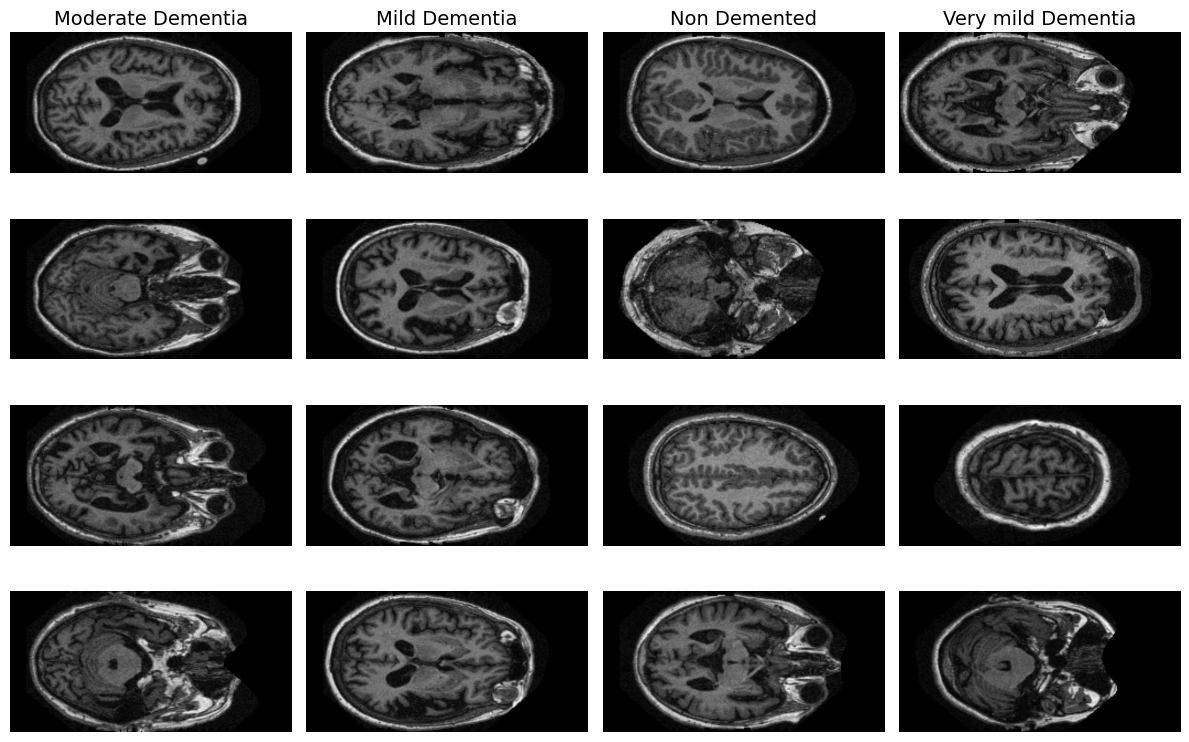

In [5]:
# Showing some images from the dataset

maxShape, diff_shape_counter = (0,0), 0
plt.figure(figsize=(12,8))

for idx, label in enumerate(class_names):
    # Get all files for this label
    label_path = os.path.join(DATASET, label)
    files = glob.glob(os.path.join(label_path, "*"))
    
    for i in range(1, 5):
        plt_index = ((i-1) * len(class_names) + idx) + 1
        
        plt.subplot(4, 4, plt_index)
        if i == 1:
            plt.title(label, fontsize=14)
            
        # Pick random image
        img_file = rng.choice(files)
        img = np.asarray(Image.open(img_file))

        if maxShape[0] < img.shape[0] or maxShape[1] < img.shape[1]:
            maxShape = img.shape
            diff_shape_counter += 1
            
        plt.imshow(img)
        plt.axis('off')

print(f"Images shape is {maxShape} {'where all images have the same dimensions' if diff_shape_counter <= 1 else f'with {diff_shape_counter} with different shapes'}")
plt.tight_layout()

**************** Label distibution/ weights ****************
Moderate Dementia : 488 
Mild Dementia : 5002 
Non Demented : 67222 
Very mild Dementia : 13725 
**************** Label distibution/ weights ****************


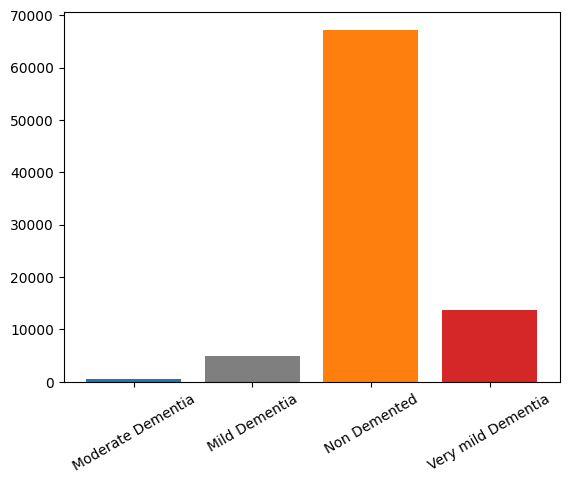

In [6]:
print("**************** Label distibution/ weights ****************")

label_counts = []
for label in class_names:
    label_path = os.path.join(DATASET, label)
    # Count files efficiently
    count = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
    label_counts.append(count)
    print(f"{label} : {count} ")

label_colors = ['tab:blue', 'tab:gray', 'tab:orange', 'tab:red']
plt.bar(class_names, label_counts, color=label_colors)
plt.xticks(rotation=30)
print("**************** Label distibution/ weights ****************")

### But before data augmenation - the data should be splitted and image sizes must be all equal 

###  Critical Note on Image Preprocessing for this dataset

Medical images possess specific anatomical ratios. Converting rectangular MRI scans (e.g., $176 \times 208$) into square inputs (e.g., $224 \times 224$) by standard resizing distorts the physical shape of the brain. 

**Why this matters:**
* **Anatomical Distortion:** "Squishing" the image changes the shape of critical structures like the hippocampus and ventricles.
* **Clinical Invalidity:** A stretched healthy brain may mimic the atrophy (shrinkage) patterns of dementia, or vice-versa, leading to false model predictions.

**Correct Method:** Always using **Padding** (adding black borders) to achieve square dimensions while preserving the original aspect ratio of the skull and brain tissue.

In [7]:

def process_and_save():
    # Walk through all folders in the source directory
    for root, dirs, files in os.walk(ORIGINAL_DATASET_PATH):
        
        # Create corresponding subfolders in the destination
        relative_path = os.path.relpath(root, ORIGINAL_DATASET_PATH)
        current_dest_dir = os.path.join(PREPROCESSED_DATASET_PATH, relative_path)
        os.makedirs(current_dest_dir, exist_ok=True)
        
        print(f"Processing folder: {relative_path}")
        
        # Loop through files
        for filename in tqdm(files):
            if filename.lower().endswith('.jpg'):
                
                img_path = os.path.join(root, filename)
                save_path = os.path.join(current_dest_dir, filename)
                
                try:
                    with Image.open(img_path) as img:
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        
                        img_array = np.array(img)
                        
                        img_padded_tensor = tf.image.resize_with_pad(
                            img_array, 
                            PREPROCESSED_IMAGE_SIZE[0], 
                            PREPROCESSED_IMAGE_SIZE[1]
                        )
                        
                        # TensorFlow resize returns floats, we need integers 0-255 for images
                        img_padded_array = img_padded_tensor.numpy().astype(np.uint8)
                        
                        #  Convert back to PIL to use .save()
                        final_img = Image.fromarray(img_padded_array)
                        
                        final_img.save(save_path, quality=95)
                        
                except Exception as e:
                    print(f"Error processing {filename}: {e}")

if os.path.isdir(PREPROCESSED_DATASET_PATH) == False:
    process_and_save()
    print("Done! All images padded and saved to new directory.")

### It is very important to notice that the dataset is unbalanced - this is not good for model training 
### because a dummy model will do very good if always detecting an image as non-demented!! 

This will basically lead to **LAZY MODEL** or in other words __BIASED MODEL__ . 

Two ways to bypass this problem:
1. **Ditch most of labels images:** (except of moderate dementia) use just 488 image for each label.
2. **Data Augmentation:** Apply transformations to the minority classes (scaling, rotating, flipping, etc.). This increases the dataset size and balance without losing valuable data from the majority class.

   **Why Augmentation is Essential:**
   Since the "Moderate" class has very few images, the model struggles to learn what it looks like. Augmentation prevents the model from memorizing specific pixels (overfitting) and forces it to learn actual features, like the shape of brain atrophy.

   **Safe Augmentations for Brain MRI:**
   * **Rotation (+/- 10 degrees):** Simulates natural head tilt during scanning.
   * **Zoom (+/- 10%):** Accounts for differences in patient head size.
   * **Horizontal Flip:** Valid because atrophy patterns can occur on either the left or right side.
   * **Brightness:** Simulates differences in MRI machine calibration.

   **What to Avoid?:** Vertical flips (upside down) or heavy shearing, as these destroy the anatomical logic of the brain.

In [8]:
def get_datagenerator():
    """
        Generate Augmentation Generator to handle data augmentation on chosen train_set label and all others train_validation (normalization)
    """
    gen = ImageDataGenerator(
        rotation_range=10,       
        zoom_range=0.1,          
        horizontal_flip=True,    
        brightness_range=[0.8, 1.2], 
        fill_mode='nearest'      
    )
    
    return gen

I chose to augment the minority class to **~1,500 images** and downsample the majority to **~4,500 images** (Ratio 1:3) rather than forcing a perfect 50/50 split.

**1. Why Limit Augmentation to 1,500 (3x) instead of 5,000 (10x)?**
* **Prevent Memorization:** Augmenting a small set of 488 images by 10x creates too many near-identical copies. The model would memorize the specific patients (overfitting) rather than learning the features of "Moderate Dementia."
* **Quality over Quantity:** A 3x increase provides enough geometric variation (rotation/zoom) for the model to learn invariance without saturating the dataset with noise.

**2. Why Keep a 1:3 Ratio instead of 1:1?**
* **Data Hunger:** Reducing the majority class to match the minority (1,500 vs 1,500) results in a total dataset of only 3,000 images. This is too small for a CNN to generalize well.
* **Preserving Variety:** By keeping ~4,500 majority images, we retain crucial anatomical diversity (different skull shapes, ages). We handle the remaining imbalance using **Class Weights** during training.

In [9]:

def load_and_process_image(path):
    """
        Loads, pads to square, and resizes a single image
        Params: 
            - path: image path
        Returns: image as array 
    """
    with Image.open(path) as img:
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return np.asarray(img)

In [10]:
# Define targets based on file counts directly
CLASSES = {}
for label in class_names:
    label_path = os.path.join(PREPROCESSED_DATASET_PATH, label)
    count = len(glob.glob(os.path.join(label_path, "*.jpg")))
    if count > 5000:
        CLASSES[label] = (4500, "downsample")
    else:
        CLASSES[label] = (1500, "augment")

# Define Augmentation (Safe for MRI)
datagen = get_datagenerator()

def Augment():
    if os.path.exists(AUGMENTED_DATASET_PATH):
        print(f"Warning: {AUGMENTED_DATASET_PATH} already exists. Please delete or rename it.")
        return

    for class_name, (target_count, mode) in CLASSES.items():
        src_path = os.path.join(PREPROCESSED_DATASET_PATH, class_name)
        dest_path = os.path.join(AUGMENTED_DATASET_PATH, class_name)
        
        os.makedirs(dest_path, exist_ok=True)
        
        # Get list of all valid images
        all_files = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg'))]

        #  DOWNSAMPLE (Drop images) ---
        if mode == "downsample":
             continue  # DOWN SAMPLE WILL BE DONE IN MEMORY

        #  AUGMENT (Create images) ---
        elif mode == "augment":
            print(f"\nProcessing {class_name} (Mode: {mode})...")
            
            #  Copy Originals first
            for f in tqdm(all_files, desc="Copying Originals"):
                shutil.copy2(os.path.join(src_path, f), os.path.join(dest_path, f))

            #  Calculate how many FAKE images we need
            current_count = len(all_files)
            needed = target_count - current_count
            
            if needed > 0:
                print(f"Generating {needed} new synthetic images...")
                
                # Create a generator that reads from the NEW destination folder (where we just copied originals)
                aug_gen = datagen.flow_from_directory(
                    directory=AUGMENTED_DATASET_PATH,
                    classes=[class_name], # Only look at this folder
                    target_size=(PREPROCESSED_IMAGE_SIZE[0], PREPROCESSED_IMAGE_SIZE[1]),
                    batch_size=1,
                    save_to_dir=dest_path, # SAVE generated images here
                    save_prefix='aug',
                    save_format='jpg'
                )
                
                # Generate until we hit the target
                count = 0
                for _ in aug_gen:
                    count += 1
                    if count >= needed:
                        break # Stop
            else:
                print("No augmentation needed (already have enough).")

Augment()
print(f"\n Labels that need to augment are now augmented and saved into {AUGMENTED_DATASET_PATH}..")


 Labels that need to augment are now augmented and saved into /home/p_es_ha/p_es_hpcgy_scratch/ASH/augmented/..


### 1. Why Standard Cross-Entropy is Flawed Here

The default loss function (`sparse_categorical_crossentropy`) treats labels as **Nominal** data (independent categories like "Cat", "Dog", "Car"), rather than **Ordinal** data (ranked categories).

* **The Reality:** This dataset's classes have a strict order: `Non (0) < Very Mild (1) < Mild (2) < Moderate (3)`.
* **The Flaw:** The model penalizes all errors equally.
    * If Truth is **Non-Demented (0)** and Prediction is **Very Mild (1)**: The model sees this as "Wrong."
    * If Truth is **Non-Demented (0)** and Prediction is **Moderate (3)**: The model sees this as "Equally Wrong."
* **Consequence:** The model fails to learn the *progression* of the disease. It doesn't understand that confusing Class 0 with Class 3 is a much worse medical error than confusing Class 0 with Class 1.

---

### 2. The Solution: The Regression Method

Instead of asking "Which bucket does this belong to?", I will teach the model to predict a **Severity Score** (a continuous number).

**Why it works:**
* Using **Mean Squared Error (MSE)** as the loss function.
* MSE penalizes **Distance**.
    * Error of 1 level (0 vs 1): Penalty is $1^2 = 1$.
    * Error of 3 levels (0 vs 3): Penalty is $3^2 = 9$.
* This forces the model to be "roughly correct" (predicting 0.2 or 0.8) rather than wildly wrong (predicting 3.0), respecting the medical order of the disease.

In [11]:
import numpy as np
import glob
import os

def prepare_data_optimized():
    # 1. Calculate TOTAL images first
    total_samples = 0
    for Class in CLASSES:
        total_samples += CLASSES[Class][0] # Add the count (e.g. 4500)
    
    print(f"Allocating memory for {total_samples} images...")

    # 2. Pre-allocate the array with 'uint8' (0-255)
    # This reserves exactly ~2.2 GB of RAM. No spikes.
    X = np.zeros((total_samples, PREPROCESSED_IMAGE_SIZE[0], PREPROCESSED_IMAGE_SIZE[1], 3), dtype='uint8')
    y = np.zeros((total_samples,), dtype='float32') # Labels are small, float is fine

  
    
    current_index = 0

    for Class in CLASSES:
        (samplesCount, mode) = CLASSES[Class]
        
        # Determine Source Directory
        if mode == "augment": 
            DATA_DIR = AUGMENTED_DATASET_PATH
        else:
            DATA_DIR = PREPROCESSED_DATASET_PATH 
            
        class_dir = os.path.join(DATA_DIR, Class)
        
        # Get Files
        all_files = glob.glob(f"{class_dir}/*")
        actual_count = min(len(all_files), samplesCount)
        
        # Random Sample
        randomSample = rng.choice(all_files, actual_count, replace=False)
        
        print(f"Loading {Class}...")
        
        for path in randomSample:
            img = load_and_process_image(path)
            
            if img is not None:
                # INSERT directly into the pre-allocated slot
                X[current_index] = img
                y[current_index] = classes_mapping[Class]
                current_index += 1

    # Trim empty slots if we found fewer images than expected
    X = X[:current_index]
    y = y[:current_index]

    return X, y




should_load = False

if 'X' not in globals() or 'y' not in globals():
    should_load = True

elif not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
    should_load = True

elif X.size == 0:
    should_load = True

if should_load:
    print("Data not found in RAM. Starting loading process...")
    X, y = prepare_data_optimized()
    print("Loading Complete!")
else:
    print(f" Data already in RAM! Skipping load.")
    print(f"Current Shapes -> X: {X.shape}, y: {y.shape}")

Data not found in RAM. Starting loading process...
Allocating memory for 15000 images...
Loading Moderate Dementia...
Loading Mild Dementia...
Loading Non Demented...
Loading Very mild Dementia...
Loading Complete!


### Model Training and Comparison




#### Load and normalize data for better training.



In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize here (Convert 0-255 to 0.0-1.0)
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0

print("Normalization Done.")

I will train two different CNN architectures to compare their performance for regression-based severity prediction.

1.  **Model 1 (Base):** A simplified CNN architecture designed for efficiency.
2.  **Model 2 (Complex):** A deeper CNN with BatchNormalization and higher filter counts, tailored to capture more complex features as per specifications.
Both models utilize **Mean Squared Error (MSE)** loss and track **Mean Absolute Error (MAE)**.

In [ ]:


# ==========================================
#  MODEL DEFINITIONS
# ==========================================

def build_model_1():
    model = models.Sequential(name="Model_1_Base")
    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5)) 
    model.add(layers.Dense(1, activation='linear'))
    return model

def build_model_2():
    model = models.Sequential(name="Model_2_Medium_GAP")
    
    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Block 4 (Deeper but handled with GAP)
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Global Average Pooling instead of Flatten
    # This averages the feature maps into a vector of size 256.
    # It massively reduces parameters compared to Flatten (which would be 14*14*256 = ~50k inputs to dense)
    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3)) 
    model.add(layers.Dense(1, activation='linear'))
    return model


### Model training

In [12]:

# Dictionary to store results
model_results = {}

# List of models to train
models_to_train = [build_model_1(), build_model_2()]

for model in models_to_train:
    print(f"\nTRAINING {model.name}...")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics=['mse']
    )
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=50, # Reduced slightly for demo purposes in script generation, increase for full run
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )
    
    model_results[model.name] = {
        'model': model,
        'history': history
    }
    print(f"{model.name} Finished!")


Normalization Done.

TRAINING Model_1_Base...
Epoch 1/50


2025-11-30 11:19:51.245725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8906
2025-11-30 11:19:52.359149: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0591426880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-30 11:19:52.359178: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-11-30 11:19:52.359183: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-11-30 11:19:52.363265: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 11:19:52.425248: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 [==============================] - 8s 16ms/step - loss: 0.4079 - mse: 0.4079 - val_loss: 0.2000 - val_mse: 0.2000
Epoch 2/50
375/375 [==============================] - 4s 11ms/step - loss: 0.2174 - mse: 0.2174 - val_loss: 0.1275 - val_mse: 0.1275
Epoch 3/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1697 - mse: 0.1697 - val_loss: 0.0965 - val_mse: 0.0965
Epoch 4/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1379 - mse: 0.1379 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 5/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1286 - mse: 0.1286 - val_loss: 0.0913 - val_mse: 0.0913
Epoch 6/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1153 - mse: 0.1153 - val_loss: 0.1140 - val_mse: 0.1140
Epoch 7/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1039 - mse: 0.1039 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 8/50
375/375 [==============================] - 4s 11ms/step - loss: 0.096

### 6. Evaluation and Comparison

We will now calculate specific regression metrics for both models to determine which performs better:

1.  **MSE (Mean Squared Error):** Average squared difference between predicted and actual values. Lower is better.
2.  **MAE (Mean Absolute Error):** Average absolute difference. Lower is better.
3.  **R2 Score:** Indicates goodness of fit (how well the model explains variance). Closer to 1.0 is better.

Since we are treating this as a regression problem, we predict a continuous score. For visualization, we can round these scores to the nearest valid class (0, 0.5, 1.0, 2.0) to see "classification-style" accuracy, though the primary metric remains regression error.


94/94 [==============================] - 1s 5ms/step


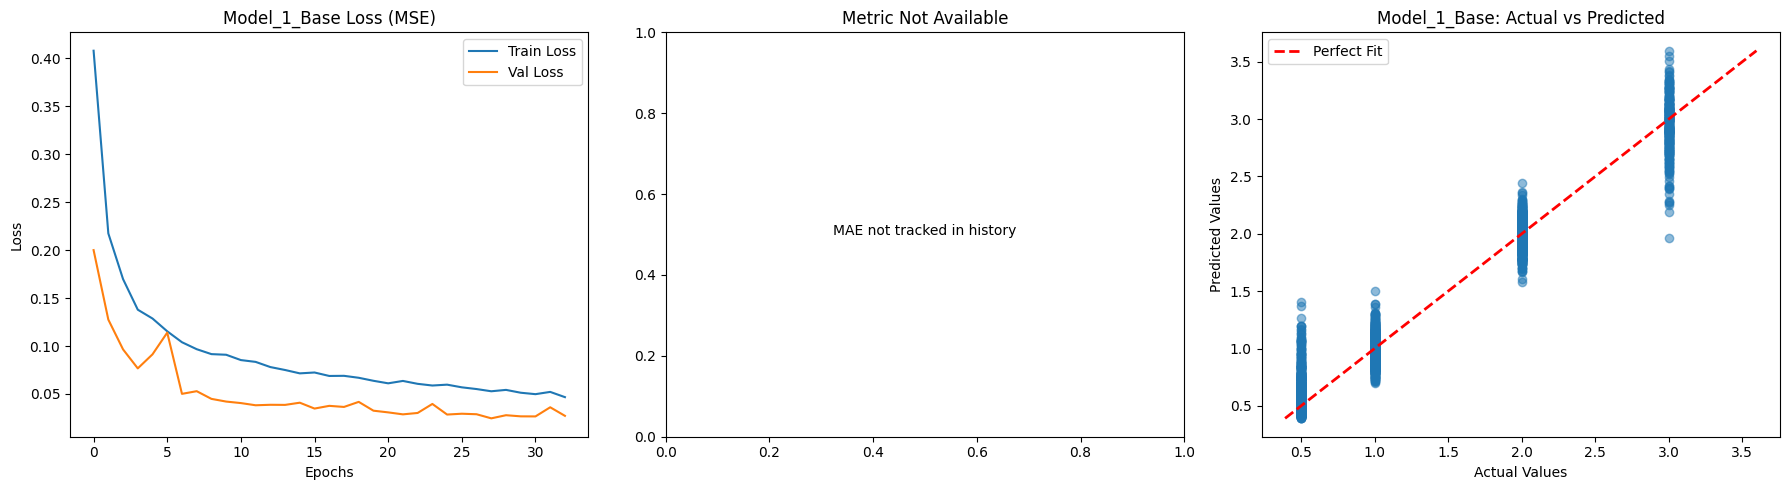

94/94 [==============================] - 1s 5ms/step


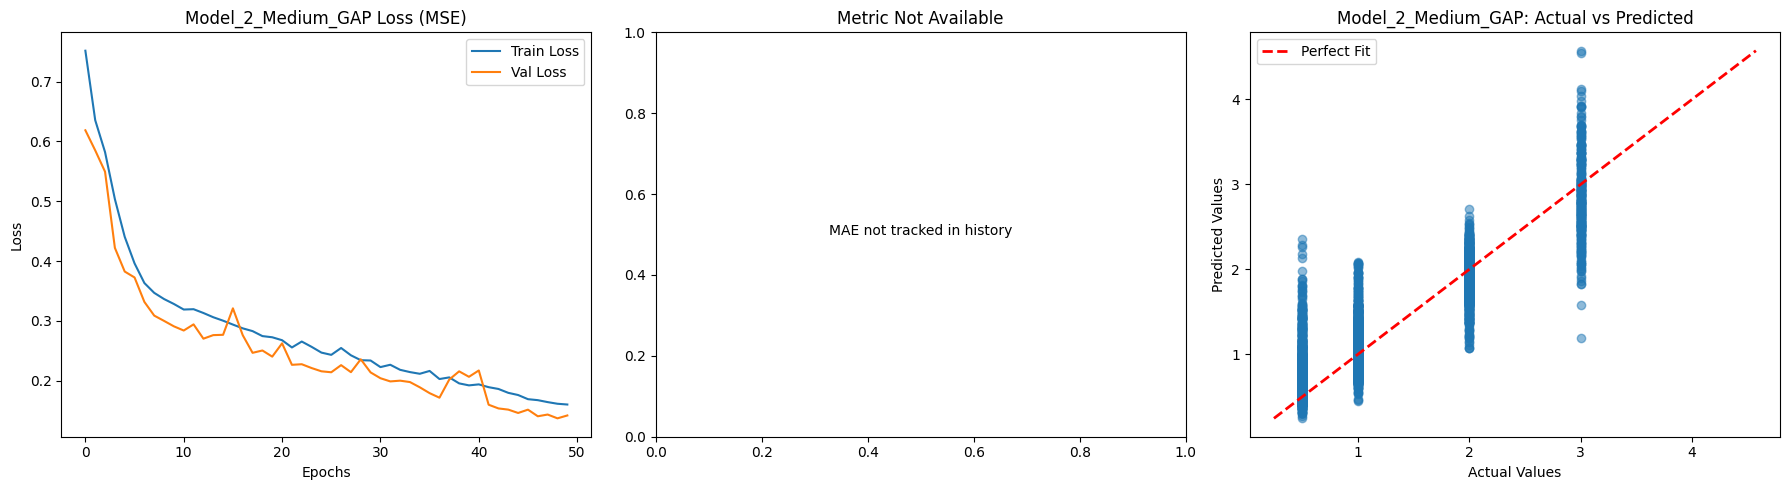


Model Comparison:
                Model       MSE      RMSE       MAE  R2 Score
0        Model_1_Base  0.024586  0.156799  0.109668  0.962320
1  Model_2_Medium_GAP  0.141794  0.376555  0.276404  0.782692


In [13]:
results_table = []

for name, data in model_results.items():
    model = data['model']
    
    # 1. Predict
    # For regression, predict returns the continuous value directly.
    # We do NOT use np.argmax here.
    y_pred = model.predict(X_test)
    
    # Flatten y_pred to ensure it matches y_test shape (e.g. convert [[1], [2]] to [1, 2])
    y_pred = y_pred.squeeze() 
    
    # 2. Calculate Regression "Accuracy" Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)               # Root Mean Squared Error (Lower is better)
    mae = mean_absolute_error(y_test, y_pred) # Mean Absolute Error (Lower is better)
    r2 = r2_score(y_test, y_pred)     # R2 Score (Closer to 1.0 is better)
    
    results_table.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2 Score": r2
    })
    
    # 3. Plotting
    plt.figure(figsize=(18, 5))
    
    # --- Plot 1: Loss Curves (MSE) ---
    plt.subplot(1, 3, 1)
    plt.plot(data['history'].history['loss'], label='Train Loss')
    plt.plot(data['history'].history['val_loss'], label='Val Loss')
    plt.title(f'{name} Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # --- Plot 2: Metric Curves (MAE) ---
    # Attempt to find MAE in history (it might be named 'mae', 'mean_absolute_error', etc.)
    hist_keys = data['history'].history.keys()
    # Find a key that contains 'mae' but is not the validation key
    mae_key = next((k for k in hist_keys if 'mae' in k.lower() and 'val' not in k), None)
    
    plt.subplot(1, 3, 2)
    if mae_key:
        val_mae_key = f'val_{mae_key}'
        plt.plot(data['history'].history[mae_key], label='Train MAE')
        if val_mae_key in data['history'].history:
            plt.plot(data['history'].history[val_mae_key], label='Val MAE')
        plt.title(f'{name} Mean Absolute Error')
        plt.ylabel('MAE')
        plt.xlabel('Epochs')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'MAE not tracked in history', ha='center')
        plt.title('Metric Not Available')

    # --- Plot 3: Actual vs Predicted (Visual Accuracy) ---
    plt.subplot(1, 3, 3)
    plt.scatter(y_test, y_pred, alpha=0.5)
    
    # Plot a perfect prediction line (Red Dashed Line)
    # If points lie on this line, the prediction is perfect.
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
    
    plt.title(f'{name}: Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Display Comparison Table
results_df = pd.DataFrame(results_table)
print("\nModel Comparison:")
# Sort by R2 Score descending (best on top)
print(results_df.sort_values(by="R2 Score", ascending=False))

### 7. Prediction & Summary

The prediction function is updated to interpret the output of the linear activation layer. The model outputs a continuous "Severity Score".


In [14]:
def predict_severity(image_path, model,label):
    try:
        # Reuse the load logic
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_array = np.array(img)
            
        # Resize with pad (ensure same logic as training)
        img_tensor = tf.image.resize_with_pad(img_array, 224, 224)
        img_array = img_tensor.numpy().astype('float32') / 255.0
        
        # Add batch dimension
        img_batch = np.expand_dims(img_array, axis=0)
        
        # Predict (returns float)
        severity_score = model.predict(img_batch)[0][0]

        
        
        # Map to nearest clinical label for display
        # 0.0: Non, 0.5: Very Mild, 1.0: Mild, 2.0: Moderate
        # We find which key in mapping is closest to the score
        inv_map = {v: k for k, v in classes_mapping.items()}
        
        # Simple distance check
        closest_val = min(classes_mapping.values(), key=lambda x: abs(x - severity_score))
        predicted_label = inv_map[closest_val]

        
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(f"Predicted Score: {severity_score:.4f}\nClinically Closest: {predicted_label}\n Actual Label {label}")
        plt.show()
        
        return severity_score
        
    except Exception as e:
        print(f"Error processing image: {e}")

# Example Usage (Picking a random test image from disk to verify)
if len(class_names) > 0:
    test_dir = os.path.join(DATASET, class_names[0])
    test_files = glob.glob(os.path.join(test_dir, "*.jpg"))
    if test_files:
        # Use the best performing model (last trained in loop usually good for demo, or pick specifically)
        best_model_name = results_df.loc[results_df['MSE'].idxmin()]['Model']
        best_model = model_results[best_model_name]['model']
        print(f"Using Best Model: {best_model_name}")
        predict_severity("test.jpg", best_model,class_names[0])


Using Best Model: Model_1_Base
Error processing image: [Errno 2] No such file or directory: 'test.jpg'


Using Best Model for Inference: Model_1_Base


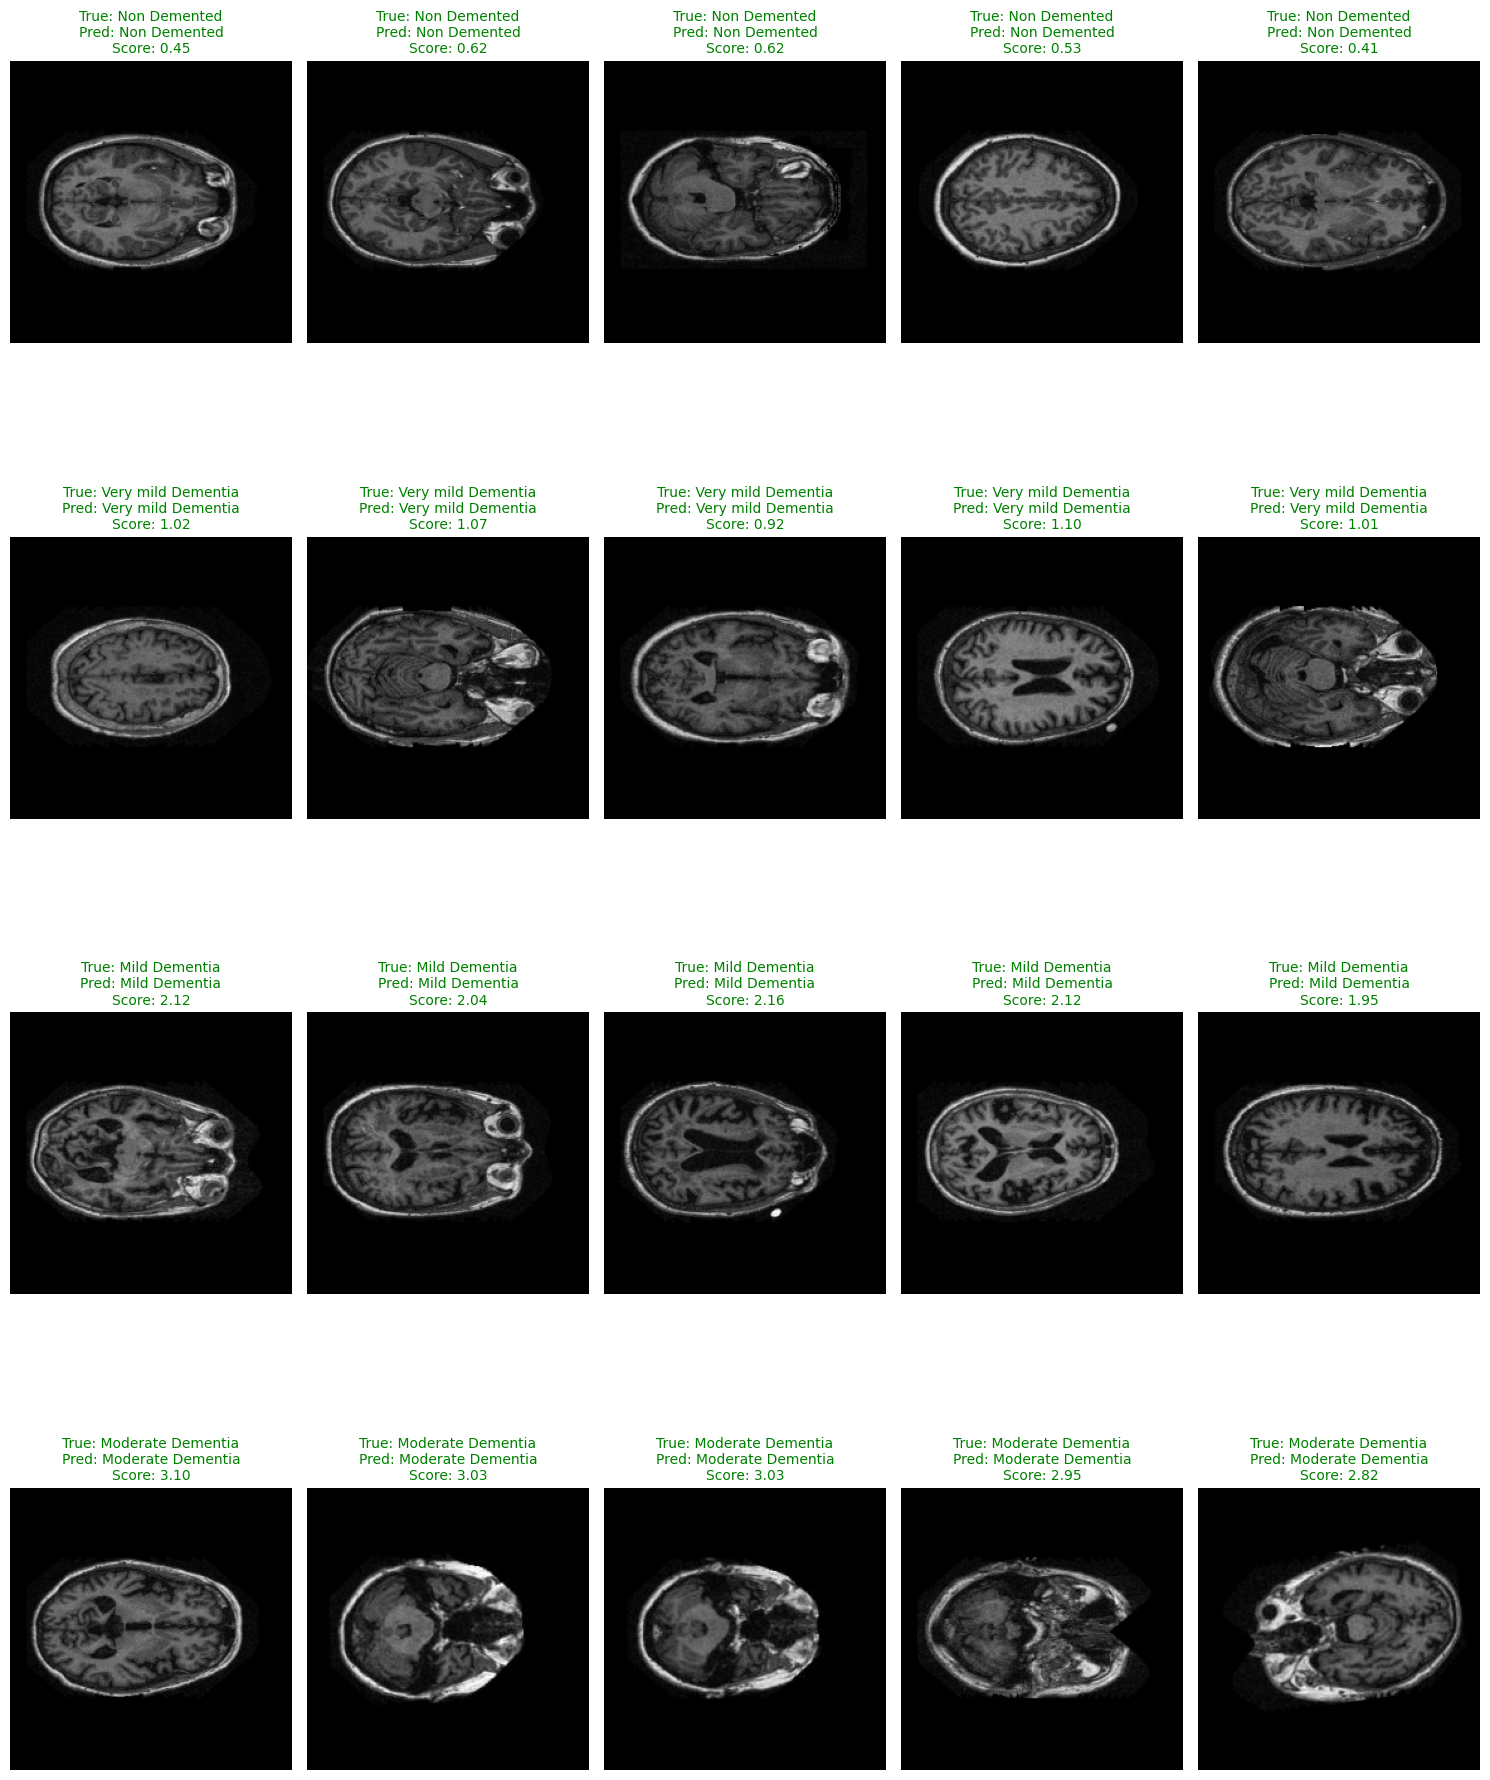

In [16]:
def predict_severity(image_path, model, label):
    try:
        # Reuse the load logic
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_array = np.array(img)
            
        # Resize with pad (ensure same logic as training)
        img_tensor = tf.image.resize_with_pad(img_array, 224, 224)
        img_array = img_tensor.numpy().astype('float32') / 255.0
        
        # Add batch dimension
        img_batch = np.expand_dims(img_array, axis=0)
        
        # Predict (returns float)
        severity_score = model.predict(img_batch, verbose=0)[0][0]
        
        # Map to nearest clinical label for display
        # 0.0: Non, 0.5: Very Mild, 1.0: Mild, 2.0: Moderate
        # We find which key in mapping is closest to the score
        inv_map = {v: k for k, v in classes_mapping.items()}
        
        # Simple distance check
        closest_val = min(classes_mapping.values(), key=lambda x: abs(x - severity_score))
        predicted_label = inv_map[closest_val]
        
        return img_array, severity_score, predicted_label
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None, None

# ----------------------------------------------------------------
# Visualization Loop: 5 Images Per Class (From X_test)
# ----------------------------------------------------------------

if len(class_names) > 0:
    # Use the best performing model
    best_model_name = results_df.loc[results_df['MSE'].idxmin()]['Model']
    best_model = model_results[best_model_name]['model']
    print(f"Using Best Model for Inference: {best_model_name}")

    num_classes = len(class_names)
    samples_per_class = 5
    
    # Setup figure
    plt.figure(figsize=(15, 5 * num_classes))
    
    plot_idx = 1
    
    # Loop through each unique class label (assuming class_names matches mapping keys)
    # Note: 'classes_mapping' maps String -> Float (e.g., 'Non': 0.0)
    # We iterate over the items to get both name and regression value
    for class_name, regression_value in classes_mapping.items():
        
        # 1. Find indices in y_test where the value matches the current class's regression value
        # y_test contains floats (0.0, 0.5, 1.0, 2.0). 
        # We allow a tiny tolerance for float comparison if needed, but exact often works for generated data.
        indices = np.where(y_test == regression_value)[0]

        if len(indices) == 0:
            continue

        # 2. Select up to 5 random indices for this class
        if len(indices) >= samples_per_class:
            selected_indices = rng.choice(indices, samples_per_class, replace=False)
        else:
            selected_indices = indices
            
        # 3. Predict and Plot for each selected sample
        for idx in selected_indices:
            # Get image data directly from X_test (already normalized 0-1)
            img_data = X_test[idx]
            
            # Predict requires a batch dimension (1, 224, 224, 3)
            img_batch = np.expand_dims(img_data, axis=0)
            
            # Predict (returns float)
            severity_score = best_model.predict(img_batch, verbose=0)[0][0]
            
            # Map score to label
            # Find the closest regression value in your mapping
            closest_val = min(classes_mapping.values(), key=lambda x: abs(x - severity_score))
            # Inverse map to get the string label ('Non', 'Mild', etc.)
            inv_map = {v: k for k, v in classes_mapping.items()}
            predicted_label = inv_map[closest_val]
            
            # Plotting
            plt.subplot(num_classes, samples_per_class, plot_idx)
            plt.imshow(img_data)
            plt.axis('off')
            
            # Color code: Green if predicted matches true class name, else Red
            color = 'green' if predicted_label == class_name else 'red'
            
            plt.title(f"True: {class_name}\nPred: {predicted_label}\nScore: {severity_score:.2f}", 
                      fontsize=10, color=color)
            
            plot_idx += 1
            
    plt.tight_layout()
    plt.show()